# No spatial features

In order to investigate the role which the spatial information plays, we've tested SG with BN (Batch Normalization), CDN, attention and bidirectional RNN without the images spatial features.

In [1]:
import numpy as np
import tensorflow as tf
import json
from datetime import datetime
import os
import sys
sys.path.append('../')
sys.path.append('../models/')
import retriever
from stats import stats
from tabulate import tabulate
from runNoSpat import RunModel as Model

%matplotlib inline  

In [2]:
trainset_file = '../data/training/train_data.bin'
testset_file = '../data/training/test_data.bin'
vocab_file =  '../data/metadata/vocab.json'
params_dir_tmp = '../data/training/models/noSpat/'

<h3>Each entry in this list has the following structure:</h3>
<ul>
<li>entry[0]: query indexes </li>
<li>entry[1:n]: n-1 items where each item is [bounding box vector, bounding box spatial features]. Note that different entries might have different number of possible  bounding boxes (i.e. different n) </li>
<li>entry[n+1]: integer, entry[ 1 + entry[n+1]] is the true bbox </li>
</ul>

In [3]:
trainset = np.load(open(trainset_file, 'rb'))

# delete data points where the query length is zero
trainset = np.array([item for item in trainset if len(item[0])!=0])

testset = np.load(open(testset_file, 'rb'))

# delete data points where the query length is zero
testset = np.array([item for item in testset if len(item[0])!=0])

# loading vocabulary 
with open(vocab_file, 'r') as f:
    vocab = json.loads(f.read())
vocab['<unk>'] = len(vocab)

print("Number of words:", len(vocab))

Number of words: 8916


<p>The graphs below show that by removing the spatial features all the model performed is significantly worsened on the test set. However, with BN layers over the image and language models the results on the train set remain the same, indicating the model's tendency to overfit even with Batch Normalization. In contrast, with CDN wee can still see a much more stable behavior and that the performance on the train set is worsen as well.</p>

<p>This show that the spatial relations between objects in the image are crucial. Note that, as we saw in the notebook located in <font color='red'>./imageOnly.ipynb</font>, without the textual information the image model can not exploit the spatial features, thus, these results show that the spatial features are important for the language models who can learn how use them effectively.</p> 



## BN

Batch Normalization over the image and language model.

In [8]:
params_dir = params_dir_tmp+'BN'
tf.reset_default_graph()
m = Model(
    batch_size=200,
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    useBnorm=True,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn = m.train(trainset, testset, epochs_num=50)

print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:1.000
Test accuracy:0.611
Train P@1:1.000
Test P@1:0.700
Train loss:0.009
Test loss:2.661


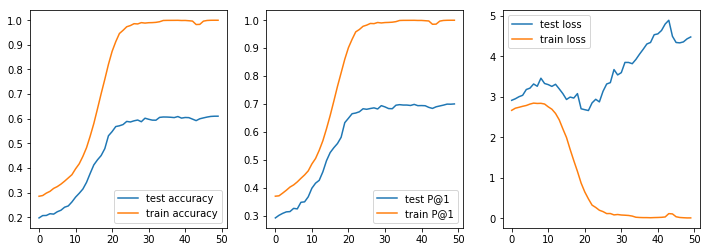

---------------------------------------------------------------------------------------------------- 



In [13]:
f = stats([tst], [trn], epochs=50, params=[200])

## CDND

CDN with dropout before and after the LSTM cell (the outputs of the Layer Normalization is scaled by 0.16 and 0.023 for the language and image models respectively)

In [23]:
params_dir = params_dir_tmp+'CDN'
tf.reset_default_graph()
m = Model(
    batch_size=200,
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    useCDN=True,
    Qscale=0.16,
    IMGscale=0.023,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn = m.train(trainset, testset, epochs_num=50, dropout_in=0.5,
        dropout_out=0.5)
    
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.730
Test accuracy:0.628
Train P@1:0.792
Test P@1:0.711
Train loss:1.352
Test loss:1.537


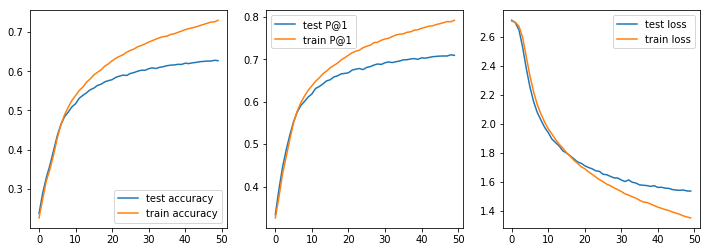

---------------------------------------------------------------------------------------------------- 



In [25]:
f = stats([tst], [trn], epochs=50, params=[200])

## CDN+Attn

Here, in addition to the DN, we've added an attention mechanism (see notebook in  <font color='red'>./SG.ipynf</font> for more details). We also added dropout before the ALSTM cell.

In [29]:
params_dir = params_dir_tmp+'CDNattn'
tf.reset_default_graph()
m = Model(
    batch_size=200,
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    useCDN=True,
    use_wordAttn=True,
    Qscale=0.16,
    IMGscale=0.023,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn = m.train(trainset, testset, epochs_num=50, dropout_in=0.5)
    
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.725
Test accuracy:0.626
Train P@1:0.789
Test P@1:0.709
Train loss:1.361
Test loss:1.539


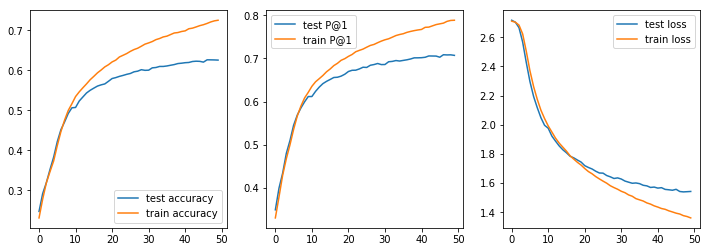

---------------------------------------------------------------------------------------------------- 



In [31]:
f = stats([tst], [trn], epochs=50, params=[200])

## BiCDND

Finally, we used CDN and a bidirectional RNN. We added dropout before the ALSTM cell.

In [33]:
params_dir = params_dir_tmp+'CDNbi'
tf.reset_default_graph()
m = Model(
    batch_size=200,
    num_hidden=200,
    img_dims=trainset[0][1][0].shape[1], 
    lr=.05,
    vocab=vocab, 
    decay_steps=10000, 
    decay_rate=0.9, 
    useCDN=True,
    useBidirectionalRnn=True,
    Qscale=0.16,
    IMGscale=0.023,
    params_dir=params_dir)


print('params_dir:', params_dir)
print('num_hidden:', m.num_hidden)
print('learning rate:', m.lr)

tst, trn = m.train(trainset, testset, epochs_num=100, dropout_in=0.5)
    
print('\n'+'*'*100)
print('*'*100)
print('*'*100,'\n')

Train accuracy:0.852
Test accuracy:0.657
Train P@1:0.890
Test P@1:0.734
Train loss:0.930
Test loss:1.487


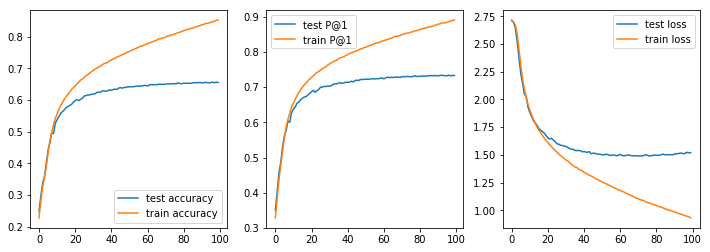

---------------------------------------------------------------------------------------------------- 



In [35]:
f = stats([tst], [trn], epochs=100, params=[200])